In [ ]:
# 필요한 라이브러리 임포트
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scipy.stats import norm
from typing import List, Tuple, Dict
import pandas as pd

# GPU 사용 설정
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available and configured")
else:
    print("No GPU found, using CPU")

# 시각화를 위한 스타일 설정
sns.set_theme(style="whitegrid")  # Seaborn 스타일 설정

# 랜덤 시드 설정
tf.random.set_seed(42)
np.random.seed(42)


GPU is available and configured


In [ ]:
# 2. NAND Flash Simulator Class
class NANDFlashSimulator:
    def __init__(self):
        """
        Initialize the QLC NAND Flash Memory Simulator
        """
        # Define 16 QLC states
        self.states = ['1111', '1110', '1101', '1100', '1011', '1010', '1001', '1000',
                       '0111', '0110', '0101', '0100', '0011', '0010', '0001', '0000']

        # Base voltage distribution parameters
        self.mu_e = 1.2  # Mean voltage for the erased state
        self.sigma_e = 0.35  # Standard deviation for the erased state
        self.sigma_p = 0.05  # Standard deviation for programmed states

        # Mean voltages for programmed states (16 levels)
        self.mu_p = np.linspace(1.5, 4.5, 16)

        # CCI parameters
        self.gamma_y = 0.08  # Vertical coupling ratio
        self.gamma_xy = 0.006  # Diagonal coupling ratio

        # Retention noise parameters
        self.At = 0.000035
        self.Bt = 0.000235
        self.alpha_i = 0.62
        self.alpha_o = 0.30

    def calculate_rtn_noise(self, PE_cycles: int) -> float:
        """
        Calculate RTN (Random Telegraph Noise)
        """
        return 0.00027 * (PE_cycles ** 0.62)

    def calculate_retention_noise(self,
                                  PE_cycles: int,
                                  retention_time: float,
                                  delta_Vt: float) -> Tuple[float, float]:
        """
        Calculate retention noise
        """
        mu_t = delta_Vt * (self.At * (PE_cycles ** self.alpha_i) +
                           self.Bt * (PE_cycles ** self.alpha_o)) * np.log(1 + retention_time)
        sigma_t = 0.3 * abs(mu_t)
        return mu_t, sigma_t

    def get_distributions(self, PE_cycles: int, retention_time: float) -> Dict[str, Tuple[float, float]]:
        """
        Generate voltage distributions for each state
        """
        distributions = {}
        sigma_r = self.calculate_rtn_noise(PE_cycles)
        for idx, state in enumerate(self.states):
            if state == '1111':
                # Erased state
                total_sigma = np.sqrt(self.sigma_e**2 + sigma_r**2)
                mu = self.mu_e
            else:
                # Programmed states
                mu_p = self.mu_p[idx]
                delta_Vt = mu_p - self.mu_e
                mu_t, sigma_t = self.calculate_retention_noise(PE_cycles, retention_time, delta_Vt)
                total_sigma = np.sqrt(self.sigma_p**2 + sigma_r**2 + sigma_t**2)
                mu = mu_p - mu_t
            distributions[state] = (mu, total_sigma)
        return distributions

    def generate_cell_voltage(self,
                              cell_state: str,
                              PE_cycles: int,
                              retention_time: float) -> float:
        """
        Generate threshold voltage for a single cell
        """
        distributions = self.get_distributions(PE_cycles, retention_time)
        mu, sigma = distributions[cell_state]
        voltage = np.random.normal(mu, sigma)
        return voltage

    def calculate_LLR(self, voltage: float, distributions: Dict[str, Tuple[float, float]]) -> List[float]:
        """
        Calculate LLR (Log-Likelihood Ratio)
        """
        num_bits = 4  # For QLC
        llr = np.zeros(num_bits)
        for bit_pos in range(num_bits):
            prob_0 = 0.0
            prob_1 = 0.0
            for state, (mu, sigma) in distributions.items():
                bit = int(state[bit_pos])
                prob = norm.pdf(voltage, mu, sigma)
                if bit == 0:
                    prob_0 += prob
                else:
                    prob_1 += prob
            llr[bit_pos] = np.log((prob_1 + 1e-12) / (prob_0 + 1e-12))
        return llr.tolist()

    def generate_voltage_distribution(self,
                                      PE_cycles: int,
                                      retention_time: float,
                                      voltage_range: Tuple[float, float] = (0, 6),
                                      num_points: int = 1000) -> Tuple[np.ndarray, List[np.ndarray]]:
        """
        Generate voltage distributions for visualization
        """
        x = np.linspace(voltage_range[0], voltage_range[1], num_points)
        distributions = []
        sigma_r = self.calculate_rtn_noise(PE_cycles)
        distributions_dict = self.get_distributions(PE_cycles, retention_time)

        for state in self.states:
            mu, sigma = distributions_dict[state]
            dist = norm.pdf(x, mu, sigma)
            distributions.append(dist)
        return x, distributions


In [ ]:
# 3. Visualization Methods
class NANDFlashVisualizer:
    @staticmethod
    def plot_figure3(simulator: NANDFlashSimulator,
                     PE_cycles: int = 1000,
                     retention_time: float = 1e5):
        """
        Figure 3: Voltage Distribution Plot
        """
        x, distributions = simulator.generate_voltage_distribution(PE_cycles, retention_time)

        plt.figure(figsize=(12, 6))

        # Plot mathematical distributions
        for i, dist in enumerate(distributions):
            plt.plot(x, dist, label=f'State {simulator.states[i]}', alpha=0.7)

        plt.title('QLC NAND Flash Memory Voltage Distribution')
        plt.xlabel('Threshold Voltage (V)')
        plt.ylabel('Probability Density')
        plt.grid(True)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_figure4(simulator: NANDFlashSimulator,
                     PE_cycles: List[int] = [3000, 4000, 5000],
                     retention_times: np.ndarray = None):
        """
        Figure 4: LLR vs Retention Time
        """
        if retention_times is None:
            retention_times = np.logspace(4, 7, 20)

        plt.figure(figsize=(10, 6))

        for PE in PE_cycles:
            LLR_values = []
            distributions = simulator.get_distributions(PE, 0)  # Initial distributions without retention
            # Select a voltage corresponding to a mid-level state
            voltage = simulator.mu_p[8]
            for t in retention_times:
                # Update distributions with retention time
                distributions = simulator.get_distributions(PE, t)
                llr_values = simulator.calculate_LLR(voltage, distributions)
                LLR_lsb = llr_values[3]  # LSB is the last bit
                LLR_values.append(LLR_lsb)

            plt.semilogx(retention_times, LLR_values, marker='o', label=f'PE={PE}')

        plt.title('Relative LLR vs Retention Time')
        plt.xlabel('Retention Time (hours)')
        plt.ylabel('Relative LLR (LSB)')
        plt.grid(True)
        plt.legend()
        plt.show()

    @staticmethod
    def plot_figure5(simulator: NANDFlashSimulator,
                     PE_cycles: int = 1000,
                     retention_time: float = 1e5):
        """
        Figure 5: CCI Effect Distribution
        """
        x, distributions = simulator.generate_voltage_distribution(PE_cycles, retention_time)

        plt.figure(figsize=(12, 6))

        total_dist = np.zeros_like(x)
        for i, dist in enumerate(distributions):
            cci_effect = simulator.gamma_y * (simulator.mu_p[i] - simulator.mu_e)
            shifted_x = x - cci_effect
            shifted_dist = np.interp(shifted_x, x, dist, left=0, right=0)
            total_dist += shifted_dist
            plt.plot(x, shifted_dist, '--', alpha=0.5,
                     label=f'CCI from state {simulator.states[i]}')

        plt.plot(x, total_dist, 'k-', label='Total Distribution', linewidth=2)

        plt.title('NAND Flash Memory Distribution with CCI Effect')
        plt.xlabel('Threshold Voltage (V)')
        plt.ylabel('Probability Density')
        plt.grid(True)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()


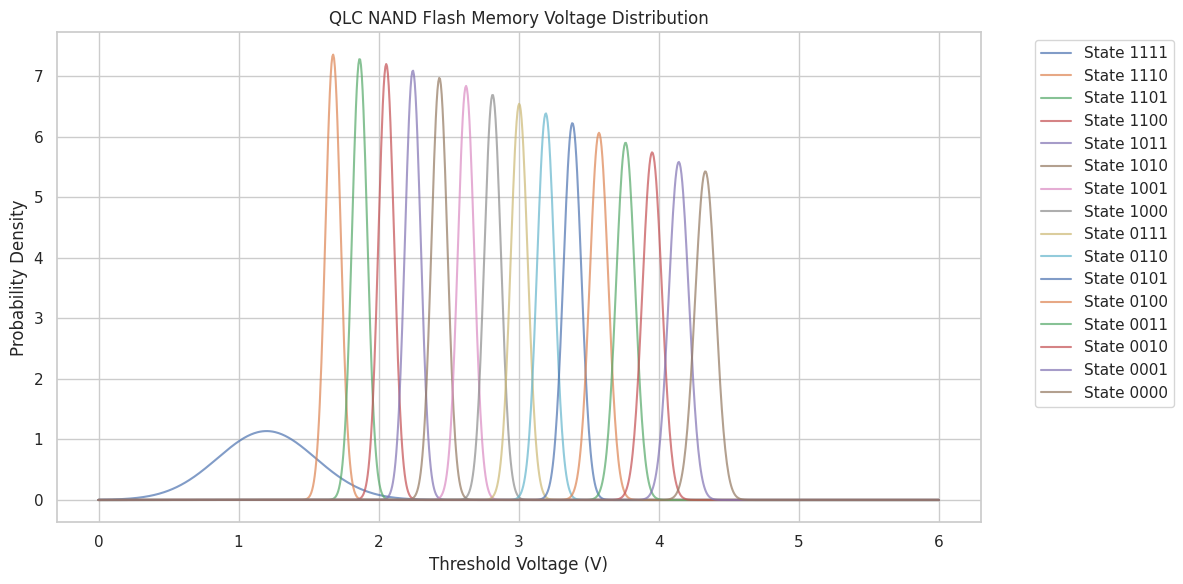

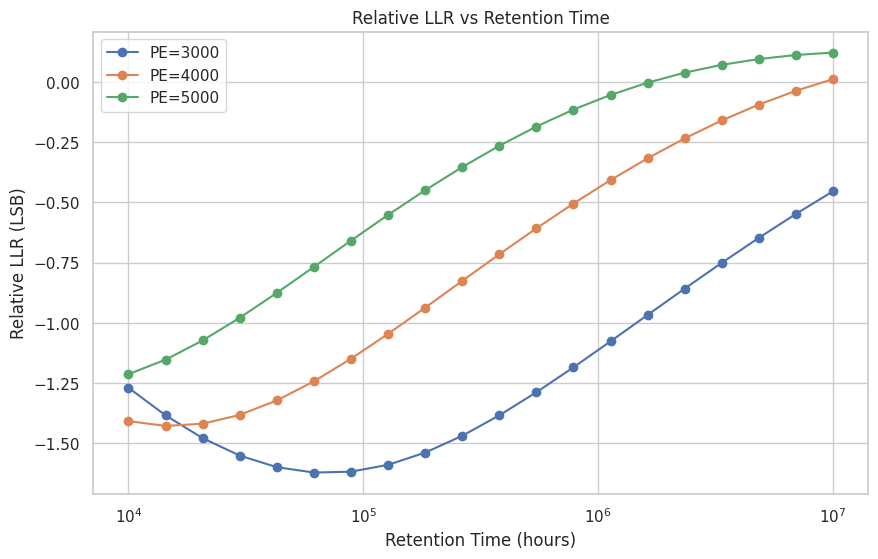

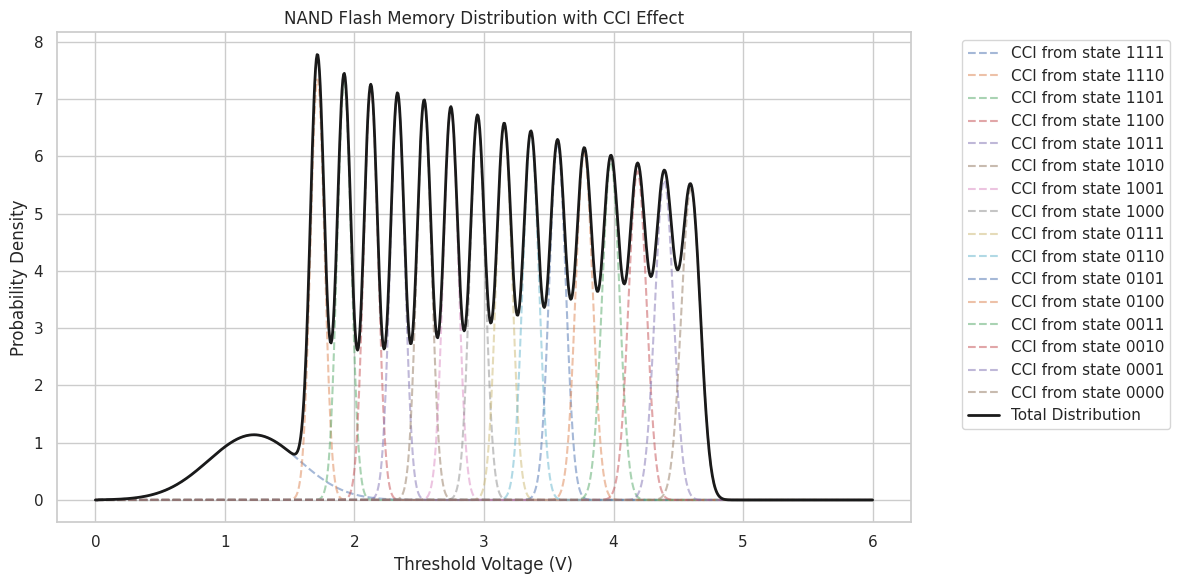

In [ ]:
# Instantiate simulator and visualizer
simulator = NANDFlashSimulator()
visualizer = NANDFlashVisualizer()

# Figure 3: Voltage Distribution Plot
visualizer.plot_figure3(simulator)

# Figure 4: LLR vs Retention Time
visualizer.plot_figure4(simulator)

# Figure 5: CCI Effect Distribution
visualizer.plot_figure5(simulator)


In [ ]:
class EnhancedNeuralErrorCorrection:
    def __init__(self, input_size: int = 8, hidden_size: int = 128):
        """
        Initialize the neural network model
        """
        tf.keras.mixed_precision.set_global_policy('mixed_float16')

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.model = self._build_model()
        self.history = None

    def _build_model(self) -> tf.keras.Model:
        """
        Build the neural network model
        """
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation='relu', input_shape=(self.input_size,), name='dense_1'),
            tf.keras.layers.BatchNormalization(name='batch_norm_1'),
            tf.keras.layers.Dense(512, activation='relu', name='dense_2'),
            tf.keras.layers.BatchNormalization(name='batch_norm_2'),
            tf.keras.layers.Dropout(0.4, name='dropout_1'),
            tf.keras.layers.Dense(256, activation='relu', name='dense_3'),
            tf.keras.layers.BatchNormalization(name='batch_norm_3'),
            tf.keras.layers.Dropout(0.4, name='dropout_2'),
            tf.keras.layers.Dense(self.hidden_size, activation='relu', name='hidden_layer'),
            tf.keras.layers.BatchNormalization(name='batch_norm_4'),
            tf.keras.layers.Dropout(0.3, name='dropout_3'),
            tf.keras.layers.Dense(2, activation='sigmoid', name='output_layer')
        ])

        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy', 'AUC']
        )

        return model

    def train(self,
              X_train: np.ndarray,
              y_train: np.ndarray,
              validation_split: float = 0.2,
              epochs: int = 200,
              batch_size: int = 64):
        """
        Train the model
        """
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=15,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=7,
                min_lr=1e-6
            )
        ]

        self.history = self.model.fit(
            X_train, y_train,
            validation_split=validation_split,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )

        return self.history

    def evaluate_model(self, X_test: np.ndarray, y_test: np.ndarray):
        """
        Evaluate the model
        """
        results = self.model.evaluate(X_test, y_test, verbose=0)
        metrics_names = ['Loss', 'Accuracy', 'AUC']

        for name, value in zip(metrics_names, results):
            print(f"{name}: {value:.4f}")

        return results


In [ ]:
class NANDFlashUtils:
    @staticmethod
    def generate_training_data(simulator: NANDFlashSimulator,
                               num_samples: int,
                               PE_cycles: int,
                               retention_time: float) -> Tuple[np.ndarray, np.ndarray]:
        """
        신경망 학습을 위한 데이터 생성
        """
        X = np.zeros((num_samples, 10))  # 입력 크기를 8에서 10으로 증가
        y = np.zeros((num_samples, 2))  # LSB와 MSB 비트 레이블

        distributions = simulator.get_distributions(PE_cycles, retention_time)

        for i in range(num_samples):
            # 현재 셀의 상태 랜덤 선택
            cell_state = np.random.choice(simulator.states)
            cell_bits = list(map(int, cell_state))
            y[i, 0] = cell_bits[3]  # LSB (비트 4)
            y[i, 1] = cell_bits[2]  # MSB (비트 3)

            # 현재 셀의 전압 생성
            voltage = simulator.generate_cell_voltage(cell_state, PE_cycles, retention_time)

            # 현재 셀의 LLR 계산
            llr_values = simulator.calculate_LLR(voltage, distributions)

            # 인접 셀들의 상태 랜덤 선택
            neighbor_states = [np.random.choice(simulator.states) for _ in range(3)]

            # 인접 셀들의 LLR 값 계산
            neighbor_llrs = []
            for neighbor_state in neighbor_states:
                neighbor_voltage = simulator.generate_cell_voltage(neighbor_state, PE_cycles, retention_time)
                neighbor_llr = simulator.calculate_LLR(neighbor_voltage, distributions)
                # LSB와 MSB의 LLR 값만 사용 (비트 3, 4)
                neighbor_llrs.extend(neighbor_llr[2:])  # llr[2], llr[3]

            # neighbor_llrs의 크기는 (6,)입니다.

            # 상대적 LLR 계산 (현재 셀과 인접 셀들의 LLR 평균 차이)
            relative_llrs = np.array(llr_values[2:])  # 현재 셀의 LSB와 MSB LLR 값
            avg_neighbor_llrs = np.mean(np.array(neighbor_llrs).reshape(3, 2), axis=0)
            relative_llrs -= avg_neighbor_llrs

            # 입력 데이터 구성
            X[i, 0:2] = relative_llrs  # 상대적 LLR 값 (LSB와 MSB)
            X[i, 2:8] = neighbor_llrs  # 인접 셀들의 LLR 값 (총 6개)
            X[i, 8] = PE_cycles / 5000  # P/E 사이클 정규화
            X[i, 9] = retention_time / 1e7  # 리텐션 시간 정규화

        return X, y


In [ ]:
# 데이터 생성 및 모델 학습 테스트
simulator = NANDFlashSimulator()
X_train, y_train = NANDFlashUtils.generate_training_data(simulator, 10000, 3000, 1e5)
X_test, y_test = NANDFlashUtils.generate_training_data(simulator, 2000, 3000, 1e5)

model = EnhancedNeuralErrorCorrection(input_size=10)
history = model.train(X_train, y_train)

# 모델 평가
results = model.evaluate_model(X_test, y_test)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - AUC: 0.7418 - accuracy: 0.6301 - loss: 0.6460 - val_AUC: 0.8754 - val_accuracy: 0.7050 - val_loss: 0.4617 - learning_rate: 5.0000e-04
Epoch 2/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8447 - accuracy: 0.6859 - loss: 0.5053 - val_AUC: 0.8904 - val_accuracy: 0.6500 - val_loss: 0.4178 - learning_rate: 5.0000e-04
Epoch 3/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8573 - accuracy: 0.6873 - loss: 0.4784 - val_AUC: 0.8934 - val_accuracy: 0.6750 - val_loss: 0.4123 - learning_rate: 5.0000e-04
Epoch 4/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8658 - accuracy: 0.6901 - loss: 0.4615 - val_AUC: 0.8948 - val_accuracy: 0.6655 - val_loss: 0.4082 - learning_rate: 5.0000e-04
Epoch 5/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8741 - accuracy: 0.6909 - loss: 0.4471 - val_AUC: 0.8953 - val_accuracy: 0.6550 - val_loss: 0.4083 - learning_rate: 5.0000e-04
Epoch 6/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

In [ ]:
# Evaluate the model
results = model.evaluate_model(X_test, y_test)


Loss: 0.3934
Accuracy: 0.6610
AUC: 0.9031


In [ ]:
# 7. Visualization of Training Metrics
class ModelVisualizer:
    @staticmethod
    def plot_training_metrics(history):
        """
        Plot training metrics
        """
        metrics = ['loss', 'accuracy', 'AUC']
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        for idx, metric in enumerate(metrics):
            axes[idx].plot(history.history[metric], label=f'Training {metric}')
            axes[idx].plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
            axes[idx].set_title(f'Model {metric.capitalize()}')
            axes[idx].set_xlabel('Epoch')
            axes[idx].set_ylabel(metric.capitalize())
            axes[idx].legend()
            axes[idx].grid(True)

        plt.tight_layout()
        plt.show()


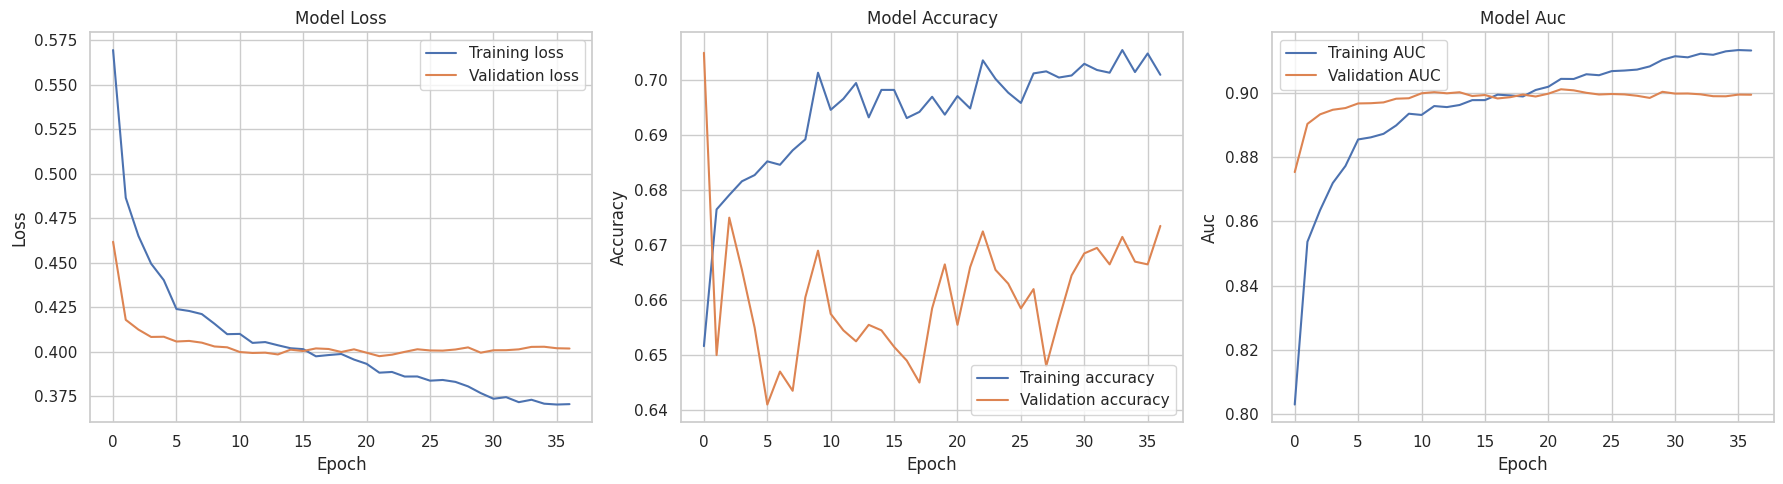

In [ ]:
# Visualize training metrics
visualizer = ModelVisualizer()
visualizer.plot_training_metrics(history)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


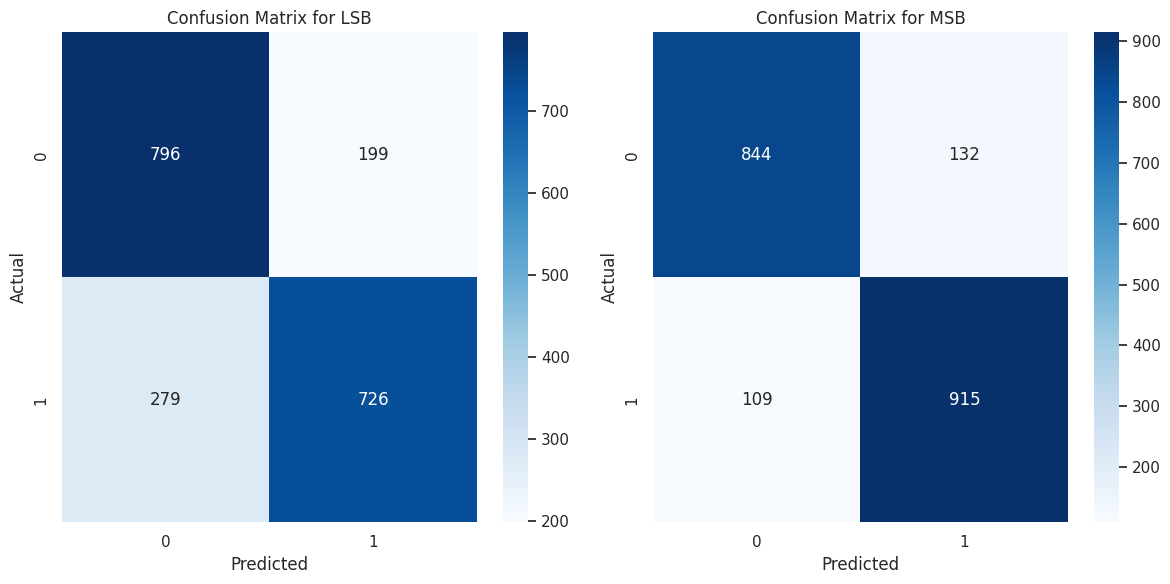

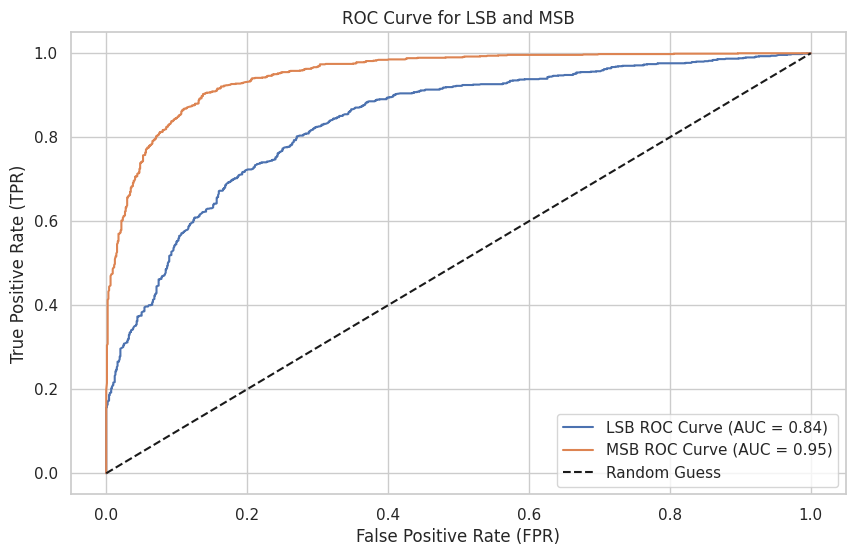

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions for test set
y_pred_probs = model.model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype(int)

# Confusion Matrix for LSB and MSB separately
confusion_lsb = confusion_matrix(y_test[:, 0], y_pred_classes[:, 0])
confusion_msb = confusion_matrix(y_test[:, 1], y_pred_classes[:, 1])

# ROC Curve for LSB and MSB
fpr_lsb, tpr_lsb, _ = roc_curve(y_test[:, 0], y_pred_probs[:, 0])
fpr_msb, tpr_msb, _ = roc_curve(y_test[:, 1], y_pred_probs[:, 1])

roc_auc_lsb = auc(fpr_lsb, tpr_lsb)
roc_auc_msb = auc(fpr_msb, tpr_msb)

# Plot confusion matrix for LSB
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_lsb, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix for LSB')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot confusion matrix for MSB
plt.subplot(1, 2, 2)
sns.heatmap(confusion_msb, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix for MSB')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_lsb, tpr_lsb, label=f'LSB ROC Curve (AUC = {roc_auc_lsb:.2f})')
plt.plot(fpr_msb, tpr_msb, label=f'MSB ROC Curve (AUC = {roc_auc_msb:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve for LSB and MSB')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# 필요한 라이브러리 설치 (필요한 경우에만 실행)
# !pip install shap
!pip install lime
# !pip install xgboost

# 1. 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from lime import lime_tabular
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 20.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=f68beeda0b1de1fc074f128ae3224601ffa12a52e89e2cecbbb8914a1eb67fdc
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
# 3. 특징 이름 정의 및 데이터프레임 생성
feature_columns = [
    'relative_llr_lsb', 'relative_llr_msb',
    'neighbor1_llr_lsb', 'neighbor1_llr_msb',
    'neighbor2_llr_lsb', 'neighbor2_llr_msb',
    'neighbor3_llr_lsb', 'neighbor3_llr_msb',
    'pe_cycles_norm', 'retention_time_norm'
]

# 3. 데이터 확인 및 변환
X_train_array = np.array(X_train)
X_test_array = np.array(X_test)
y_train_array = np.array(y_train)
y_test_array = np.array(y_test)

df_X_train = pd.DataFrame(X_train_array, columns=feature_columns)
df_X_test = pd.DataFrame(X_test_array, columns=feature_columns)

In [ ]:
# LSB에 대해서만 분석 (첫 번째 열 선택)
y_train_lsb = y_train_array[:, 0]
y_test_lsb = y_test_array[:, 0]

# Random Forest 모델 학습 및 평가
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_array, y_train_lsb)

# 예측 수행
y_pred_rf = rf_model.predict(X_test_array)
y_pred_prob_rf = np.array(rf_model.predict_proba(X_test_array))

print("\nRandom Forest 모델 성능 (LSB):")
print(f"Accuracy: {accuracy_score(y_test_lsb, y_pred_rf):.4f}")
print(f"AUC: {roc_auc_score(y_test_lsb, y_pred_prob_rf[:, 1]):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_lsb, y_pred_rf))


Random Forest 모델 성능 (LSB):
Accuracy: 0.7460
AUC: 0.8276

Confusion Matrix:
[[780 215]
 [293 712]]


In [ ]:
# XGBoost 모델 학습 및 평가
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train_array, y_train_lsb)

# 예측 수행
y_pred_xgb = xgb_model.predict(X_test_array)
y_pred_prob_xgb = np.array(xgb_model.predict_proba(X_test_array))

print("\nXGBoost 모델 성능 (LSB):")
print(f"Accuracy: {accuracy_score(y_test_lsb, y_pred_xgb):.4f}")
print(f"AUC: {roc_auc_score(y_test_lsb, y_pred_prob_xgb[:, 1]):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_lsb, y_pred_xgb))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:30:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost 모델 성능 (LSB):
Accuracy: 0.7455
AUC: 0.8228

Confusion Matrix:
[[759 236]
 [273 732]]


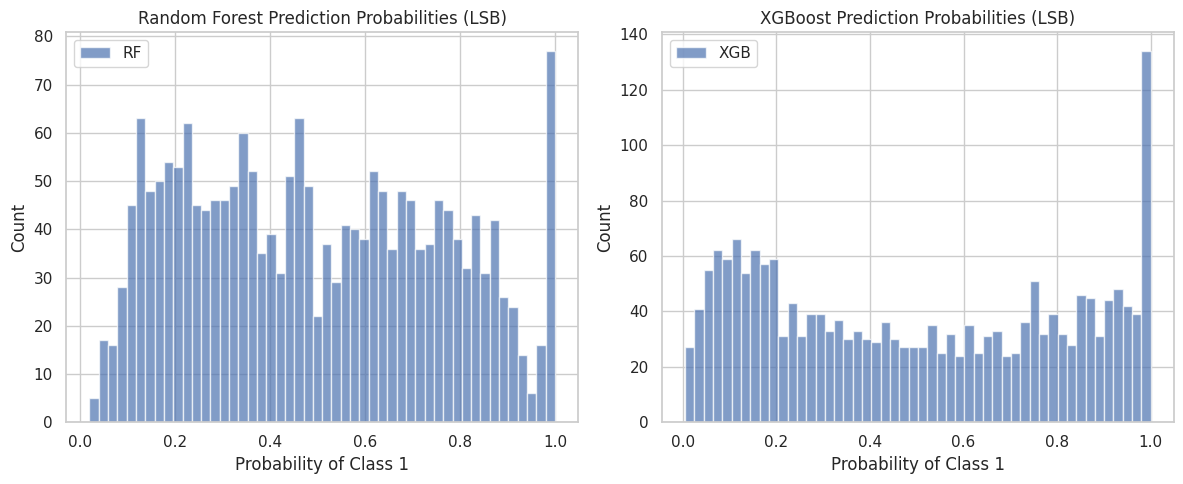

In [ ]:
# 예측 확률 분포 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y_pred_prob_rf[:, 1], bins=50, alpha=0.7, label='RF')
plt.title('Random Forest Prediction Probabilities (LSB)')
plt.xlabel('Probability of Class 1')
plt.ylabel('Count')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(y_pred_prob_xgb[:, 1], bins=50, alpha=0.7, label='XGB')
plt.title('XGBoost Prediction Probabilities (LSB)')
plt.xlabel('Probability of Class 1')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

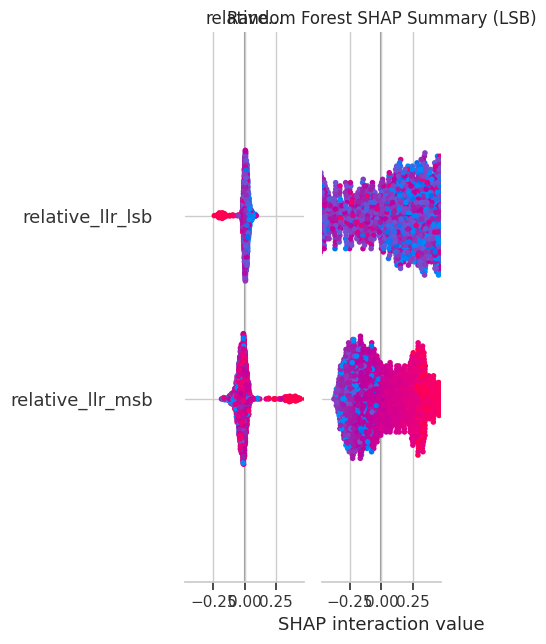

In [ ]:
# 모델 설명을 위한 SHAP 분석 준비
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test_array)

# SHAP 값 시각화
plt.figure(figsize=(10, 6))
if isinstance(shap_values_rf, list):
    shap_values_plot = shap_values_rf[1]
else:
    shap_values_plot = shap_values_rf

shap.summary_plot(
    shap_values_plot,
    df_X_test,
    show=False
)
plt.title("Random Forest SHAP Summary (LSB)")
plt.tight_layout()
plt.show()

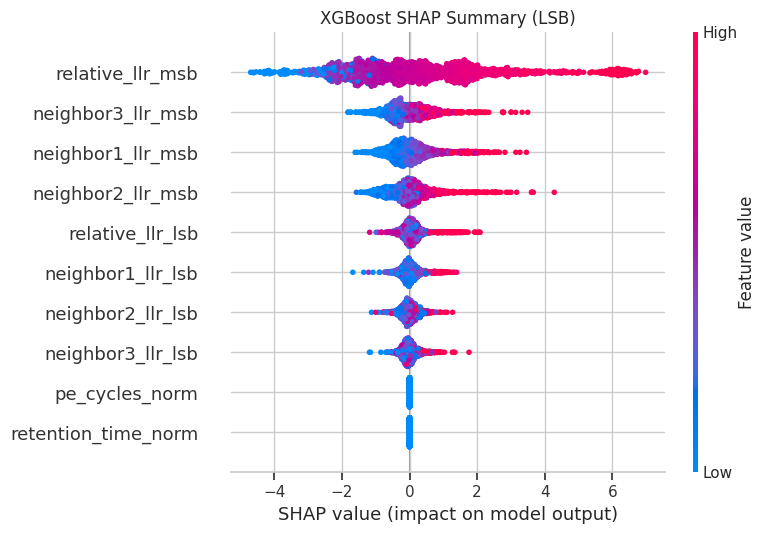

In [ ]:
# XGBoost SHAP 분석
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test_array)

plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_xgb,
    df_X_test,
    show=False
)
plt.title("XGBoost SHAP Summary (LSB)")
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

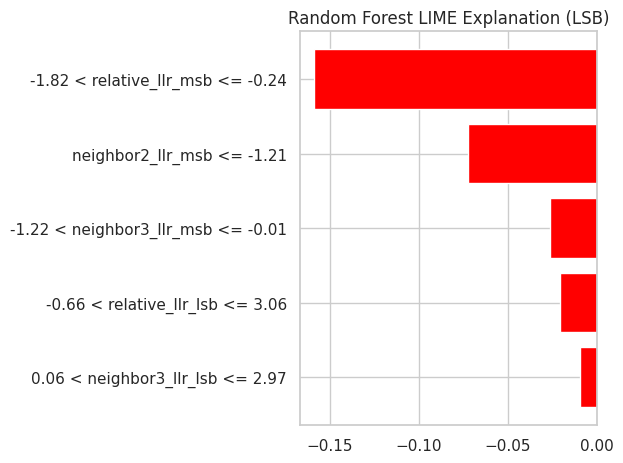

In [ ]:
# LIME 분석
lime_explainer = lime_tabular.LimeTabularExplainer(
    X_train_array,
    feature_names=feature_columns,
    class_names=['0', '1'],
    discretize_continuous=True,
    random_state=42
)

# Random Forest LIME 분석
i = 0  # 첫 번째 테스트 샘플
exp_rf = lime_explainer.explain_instance(
    X_test_array[i],
    rf_model.predict_proba,
    num_features=5
)

plt.figure(figsize=(10, 6))
exp_rf.as_pyplot_figure()
plt.title("Random Forest LIME Explanation (LSB)")
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

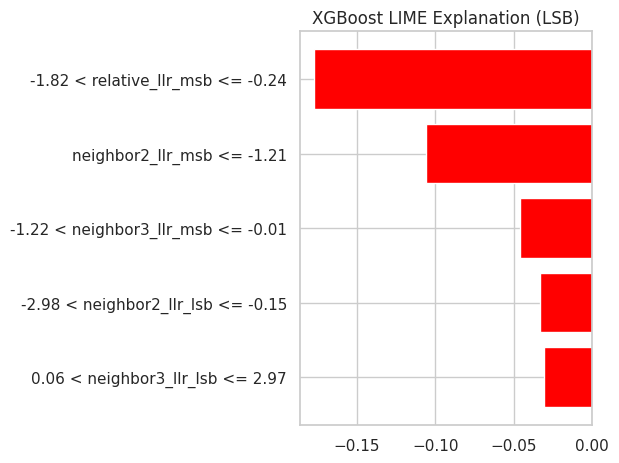

In [ ]:
# XGBoost LIME 분석
exp_xgb = lime_explainer.explain_instance(
    X_test_array[i],
    xgb_model.predict_proba,
    num_features=5
)

plt.figure(figsize=(10, 6))
exp_xgb.as_pyplot_figure()
plt.title("XGBoost LIME Explanation (LSB)")
plt.tight_layout()
plt.show()

In [ ]:
# 특징 중요도 비교
rf_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

xgb_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n특징 중요도 순위 (LSB):")
print("\nRandom Forest:")
print(rf_importance)
print("\nXGBoost:")
print(xgb_importance)


특징 중요도 순위 (LSB):

Random Forest:
               feature  importance
1     relative_llr_msb    0.309999
0     relative_llr_lsb    0.112317
5    neighbor2_llr_msb    0.105862
7    neighbor3_llr_msb    0.103820
3    neighbor1_llr_msb    0.103509
6    neighbor3_llr_lsb    0.088445
4    neighbor2_llr_lsb    0.088180
2    neighbor1_llr_lsb    0.087867
8       pe_cycles_norm    0.000000
9  retention_time_norm    0.000000

XGBoost:
               feature  importance
1     relative_llr_msb    0.372632
3    neighbor1_llr_msb    0.108420
7    neighbor3_llr_msb    0.107383
5    neighbor2_llr_msb    0.105671
6    neighbor3_llr_lsb    0.078569
2    neighbor1_llr_lsb    0.077664
0     relative_llr_lsb    0.074844
4    neighbor2_llr_lsb    0.074818
8       pe_cycles_norm    0.000000
9  retention_time_norm    0.000000
